## Implementation of the paper: "The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks" on ResNet50 Image Classification Model

# Authors: Yusuf ASLAN, Ali Esad UĞUR, Feray Lina YENCE
# Date: 26.05.2023

# Importing Necessary Libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses

# Lottery Ticket Hypothesis Algorithm to Prune Models

In [7]:
def iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, num_iterations, prune_percentage, model):    
    # Early Stopping criterion will be used in model fitting
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, min_delta=0.001, start_from_epoch=20)

    percentage = prune_percentage
    weight_rate = 100
    history_list = []

    for iteration in range(num_iterations):
      weight_rate = weight_rate - (weight_rate * (prune_percentage/100))
      percentage = 100 - weight_rate
    
      print(f"Iteration {iteration+1} / {num_iterations} ")
      # Identify important weights based on magnitudes
      weights = model.get_weights()
      magnitudes = [np.abs(w).flatten() for w in weights]
      importance = np.concatenate(magnitudes)
      threshold = np.percentile(importance, percentage)
    

      # Prune the least important weights
      pruned_weights = [np.where(np.abs(w) < threshold, 0, w) for w in weights]
      model.set_weights(pruned_weights)
    
      # fine-tune the pruned model
      history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))
      history_list.append(history)

    return model, history_list

# Loading and preparing MNIST Dataset 

In [8]:
# loading data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# data normalization
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

# splitting data
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

# Creating and Training Base Model : ResNet50

In [9]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, min_delta=0.001, start_from_epoch=20)

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
# Train the model
history1 = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
454/454 [==============================] - 18s 24ms/step - loss: 0.6784 - accuracy: 0.7906 - val_loss: 0.3183 - val_accuracy: 0.9185
Epoch 2/20
454/454 [==============================] - 9s 19ms/step - loss: 0.3602 - accuracy: 0.8845 - val_loss: 0.2402 - val_accuracy: 0.9320
Epoch 3/20
454/454 [==============================] - 10s 23ms/step - loss: 0.3028 - accuracy: 0.9023 - val_loss: 0.2722 - val_accuracy: 0.9135
Epoch 4/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2780 - accuracy: 0.9108 - val_loss: 0.2864 - val_accuracy: 0.9055
Epoch 5/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2563 - accuracy: 0.9171 - val_loss: 0.2009 - val_accuracy: 0.9360
Epoch 6/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2385 - accuracy: 0.9231 - val_loss: 0.1910 - val_accuracy: 0.9450
Epoch 7/20
454/454 [==============================] - 8s 17ms/step - loss: 0.2224 - accuracy: 0.9285 - val_loss: 0.2002 - val_accuracy: 0.93

# One-Shot Pruning Approach of Lottery Ticket Hypothesis (We have pruned 20% weights)

In [10]:
# Copying the model to compare original and pruned model in future
pruned_model = clone_model(model)

# Compile the model
pruned_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model (One-shot 20% pruning)
pruned_model, history2 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 1, 20, pruned_model)

Iteration 1 / 1 
Epoch 1/20
454/454 [==============================] - 13s 20ms/step - loss: 1.1660 - accuracy: 0.6851 - val_loss: 0.5094 - val_accuracy: 0.8905
Epoch 2/20
454/454 [==============================] - 8s 18ms/step - loss: 0.4911 - accuracy: 0.8606 - val_loss: 0.3257 - val_accuracy: 0.9150
Epoch 3/20
454/454 [==============================] - 8s 17ms/step - loss: 0.3655 - accuracy: 0.8925 - val_loss: 0.2530 - val_accuracy: 0.9405
Epoch 4/20
454/454 [==============================] - 8s 18ms/step - loss: 0.3068 - accuracy: 0.9094 - val_loss: 0.2096 - val_accuracy: 0.9450
Epoch 5/20
454/454 [==============================] - 8s 17ms/step - loss: 0.2723 - accuracy: 0.9179 - val_loss: 0.1946 - val_accuracy: 0.9500
Epoch 6/20
454/454 [==============================] - 8s 17ms/step - loss: 0.2493 - accuracy: 0.9245 - val_loss: 0.1867 - val_accuracy: 0.9500
Epoch 7/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2304 - accuracy: 0.9309 - val_loss: 0.1762 - va

## Plotting Train and Test accuracies of Original and 20% pruned models

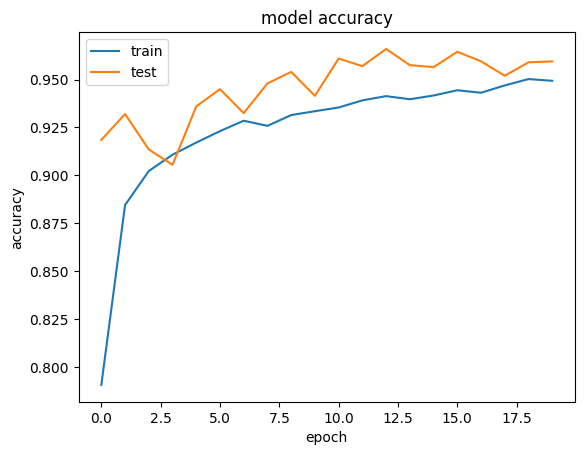

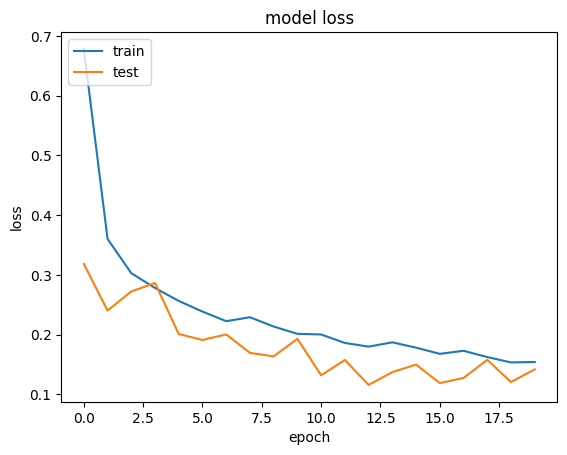

In [11]:
# Plots for model itself
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

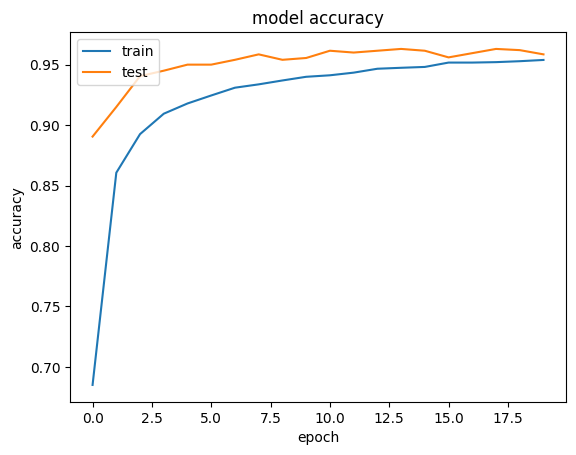

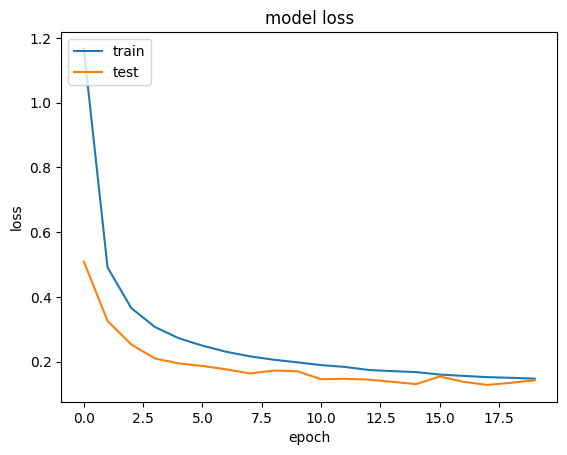

In [12]:
# Plots for pruned model (One-shot 20% pruning)

# Summarize history for accuracy
plt.plot(history2[0].history['accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history2[0].history['loss'])
plt.plot(history2[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Comparing Train and Test accuracies of Original and 20% pruned models

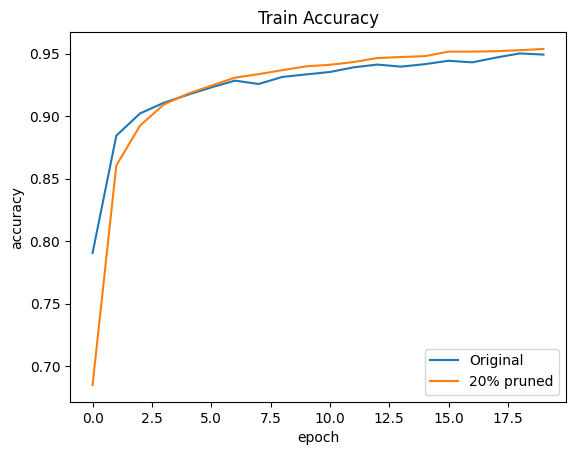

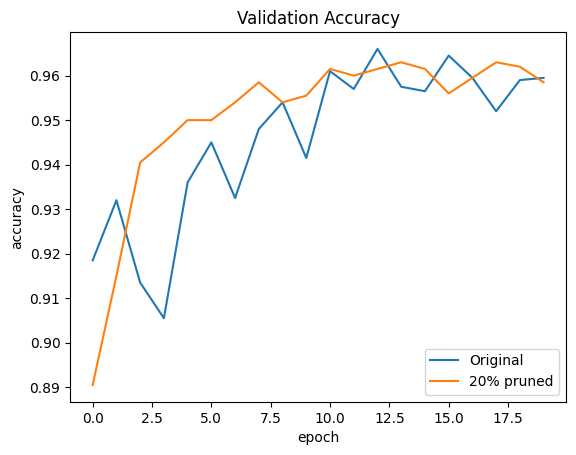

In [13]:
# Compare Train accuracies of original model and 20% pruning
plt.plot(history1.history['accuracy'])
plt.plot(history2[0].history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '20% pruned'], loc='lower right')
plt.show()

# Compare Validation accuracies of original model and 20% pruning
plt.plot(history1.history['val_accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '20% pruned'], loc='lower right')
plt.show()

## Printing Maximum Train and Test accuracies of Original and 20% pruned models

In [14]:
# Best train accuracy of original model
max_tr_acc_original = max(history1.history["accuracy"])
print(f"Highest Train Accuracy of original Resnet152 Model: {max_tr_acc_original}") 

# Best train accuracy of 20% pruned model
max_tr_acc_pruned20 = max(history2[0].history["accuracy"])
print(f"Highest Train Accuracy of 20% Pruned Resnet152 Model: {max_tr_acc_pruned20}") 


Highest Train Accuracy of original Resnet152 Model: 0.9502586126327515
Highest Train Accuracy of 20% Pruned Resnet152 Model: 0.9538792967796326


In [15]:
# Best validation accuracy of original model
max_val_acc_original = max(history1.history["val_accuracy"])
print(f"Highest Validation Accuracy of original Resnet50 Model: {max_val_acc_original}") 

# Best validation accuracy of 20% pruned model
max_val_acc_pruned20 = max(history2[0].history["val_accuracy"])
print(f"Highest Validation Accuracy of 20% Pruned Resnet50 Model: {max_val_acc_pruned20}") 

Highest Validation Accuracy of original Resnet50 Model: 0.9660000205039978
Highest Validation Accuracy of 20% Pruned Resnet50 Model: 0.9629999995231628


# One-Shot Pruning Approach of Lottery Ticket Hypothesis (We have pruned 50% weights)

## Plotting and printing necessary informations

Iteration 1 / 1 
Epoch 1/20
454/454 [==============================] - 48s 100ms/step - loss: 1.2570 - accuracy: 0.6534 - val_loss: 0.5422 - val_accuracy: 0.8770
Epoch 2/20
454/454 [==============================] - 8s 18ms/step - loss: 0.5419 - accuracy: 0.8457 - val_loss: 0.3406 - val_accuracy: 0.9220
Epoch 3/20
454/454 [==============================] - 8s 18ms/step - loss: 0.4021 - accuracy: 0.8838 - val_loss: 0.2532 - val_accuracy: 0.9395
Epoch 4/20
454/454 [==============================] - 8s 18ms/step - loss: 0.3333 - accuracy: 0.9013 - val_loss: 0.2168 - val_accuracy: 0.9440
Epoch 5/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2939 - accuracy: 0.9122 - val_loss: 0.1894 - val_accuracy: 0.9535
Epoch 6/20
454/454 [==============================] - 8s 17ms/step - loss: 0.2660 - accuracy: 0.9200 - val_loss: 0.1751 - val_accuracy: 0.9515
Epoch 7/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2471 - accuracy: 0.9252 - val_loss: 0.1684 - v

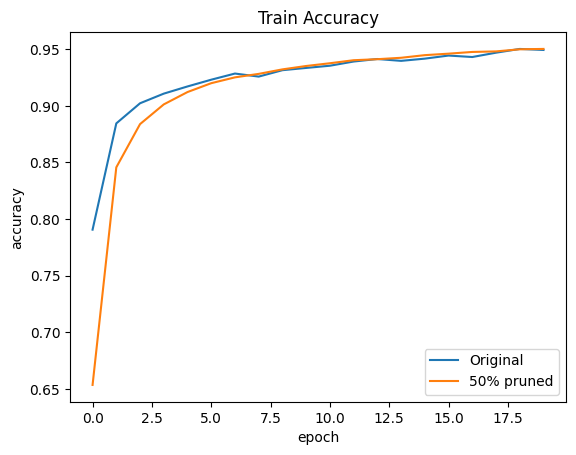

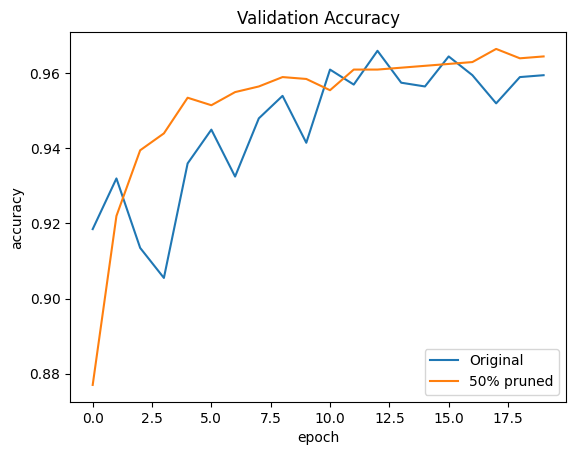

Highest Train Accuracy of original Resnet50 Model: 0.9502586126327515
Highest Train Accuracy of 50% Pruned Resnet50 Model: 0.9502758383750916
Highest Validation Accuracy of original Resnet50 Model: 0.9660000205039978
Highest Validation Accuracy of 50% Pruned Resnet50 Model: 0.9664999842643738


In [29]:
# Copying the model to compare original and pruned model in future
pruned_model = clone_model(model)

# Compile the model
pruned_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model (One-shot 50% pruning)
pruned_model, history2 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 1, 50, pruned_model)

# Compare Train accuracies of original model and 50% pruning
plt.plot(history1.history['accuracy'])
plt.plot(history2[0].history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '50% pruned'], loc='lower right')
plt.show()

# Compare Validation accuracies of original model and 50% pruning
plt.plot(history1.history['val_accuracy'])
plt.plot(history2[0].history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '50% pruned'], loc='lower right')
plt.show()

# Best train accuracy of original model
max_tr_acc_original = max(history1.history["accuracy"])
print(f"Highest Train Accuracy of original Resnet50 Model: {max_tr_acc_original}") 

# Best train accuracy of 50% pruned model
max_tr_acc_pruned50 = max(history2[0].history["accuracy"])
print(f"Highest Train Accuracy of 50% Pruned Resnet50 Model: {max_tr_acc_pruned50}") 


# Best validation accuracy of original model
max_val_acc_original = max(history1.history["val_accuracy"])
print(f"Highest Validation Accuracy of original Resnet50 Model: {max_val_acc_original}") 

# Best validation accuracy of 50% pruned model
max_val_acc_pruned50 = max(history2[0].history["val_accuracy"])
print(f"Highest Validation Accuracy of 50% Pruned Resnet50 Model: {max_val_acc_pruned50}") 

# Iterative Pruning Approach of Lottery Ticket Hypothesis (7 iterations until we have almost 20% weights)

## Training Models and Getting Results

In [16]:
# Copying the model to compare original and pruned model in future
pruned_model2 = clone_model(model)

# Compile the model
pruned_model2.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Running Lotttery Ticket Hypothesis on the model
pruned_model2, history3 = iterative_pruning_lottery_ticket(x_train, y_train, x_val, y_val, 7, 20, pruned_model2)

Iteration 1 / 7 
Epoch 1/20
454/454 [==============================] - 13s 21ms/step - loss: 1.2381 - accuracy: 0.6419 - val_loss: 0.5417 - val_accuracy: 0.8630
Epoch 2/20
454/454 [==============================] - 8s 17ms/step - loss: 0.5542 - accuracy: 0.8361 - val_loss: 0.3610 - val_accuracy: 0.9050
Epoch 3/20
454/454 [==============================] - 8s 18ms/step - loss: 0.4212 - accuracy: 0.8757 - val_loss: 0.2790 - val_accuracy: 0.9310
Epoch 4/20
454/454 [==============================] - 8s 18ms/step - loss: 0.3546 - accuracy: 0.8938 - val_loss: 0.2481 - val_accuracy: 0.9320
Epoch 5/20
454/454 [==============================] - 8s 17ms/step - loss: 0.3162 - accuracy: 0.9043 - val_loss: 0.2256 - val_accuracy: 0.9370
Epoch 6/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2866 - accuracy: 0.9126 - val_loss: 0.2012 - val_accuracy: 0.9495
Epoch 7/20
454/454 [==============================] - 8s 18ms/step - loss: 0.2656 - accuracy: 0.9188 - val_loss: 0.1995 - va

## Plotting Train Accuracies of Original and All Pruned Models

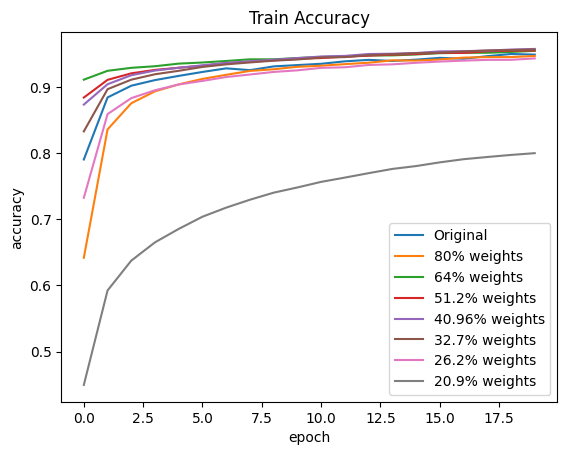

In [20]:
# Compare Train accuracies of original model and prunings
prune_rates = ['Original', '80% weights', '64% weights', '51.2% weights', '40.96% weights', '32.7% weights', '26.2% weights','20.9% weights']

plt.plot(history1.history['accuracy'])

for h in history3:
  plt.plot(h.history['accuracy'])

plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(prune_rates, loc='lower right')
plt.show()

## Plotting Validation Accuracies of Original and All Pruned Models

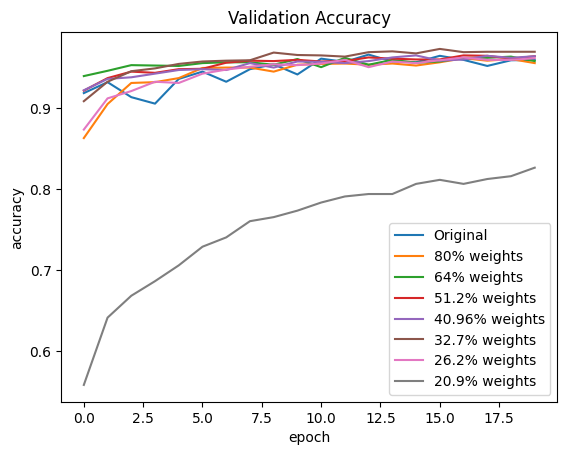

In [21]:
# Compare Validation accuracies of original model and prunings
plt.plot(history1.history['val_accuracy'])

for h in history3:
  plt.plot(h.history['val_accuracy'])

plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(prune_rates, loc='lower right')
plt.show()

## Showing Maximum Train and Test Accuracies of Original and All Pruned Models

In [28]:
# Max train accuracies for all prune rates
print("Max train accuracies for ResNet50 network: ")
print(f"with prune rate {prune_rates[0]} : {max(history1.history['accuracy'])}")

for i in range(len(prune_rates[1:])):
   print(f"with prune rate {prune_rates[i+1]} : {max(history3[i].history['accuracy'])}")

print("\nMax test accuracies for ResNet50 network: ")
print(f"with prune rate {prune_rates[0]} : {max(history1.history['val_accuracy'])}")
# Max validation accuracies for all prune rates
for i in range(len(prune_rates[1:])):
   print(f"with prune rate {prune_rates[i+1]} : {max(history3[i].history['val_accuracy'])}")


Max train accuracies for ResNet50 network: 
with prune rate Original : 0.9502586126327515
with prune rate 80% weights : 0.9472585916519165
with prune rate 64% weights : 0.9550172686576843
with prune rate 51.2% weights : 0.9555517435073853
with prune rate 40.96% weights : 0.9579310417175293
with prune rate 32.7% weights : 0.9570000171661377
with prune rate 26.2% weights : 0.9435517191886902
with prune rate 20.9% weights : 0.8001723885536194

Max test accuracies for ResNet50 network: 
with prune rate Original : 0.9660000205039978
with prune rate 80% weights : 0.9614999890327454
with prune rate 64% weights : 0.9635000228881836
with prune rate 51.2% weights : 0.9649999737739563
with prune rate 40.96% weights : 0.9649999737739563
with prune rate 32.7% weights : 0.9729999899864197
with prune rate 26.2% weights : 0.9624999761581421
with prune rate 20.9% weights : 0.8264999985694885


## Comparing Parameter Counts of Resnet50 and Resnet152 Models

In [37]:
# To show and compare networks sizes and parameter counts

# ResNet50 net
res50 = ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in res50.layers:
  layer.trainable = False

x = Flatten()(res50.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

# ResNet152 net
res152 =  tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in res152.layers:
  layer.trainable = False

x = Flatten()(res152.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(10, activation = 'softmax')(x)


print(f"Total parameter count of 'ResNet50 network' : {res50.count_params():,}")
print(f"Total parameter count of 'ResNet152 network' : {res152.count_params():,}")


Total parameter count of 'ResNet50 network' : 23,587,712
Total parameter count of 'ResNet152 network' : 58,370,944


## Showing Network Structures of the Two Models

In [38]:
# show all layers of ResNet50 net
res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [39]:
# show all layers of ResNet152 net
res152.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                          